Using Design Matrix as described in this [Coursera Lesson](https://class.coursera.org/gpslab-001/lecture/27)

MATLAB Least Squares + Extended Kalman implementation [here](https://www.mathworks.com/matlabcentral/fileexchange/31487-extended-kalman-filter-ekf--for-gps/content/EKF/GPS_EKF.m)

Other MATLAB code (RAIM, etc.) [here](http://kom.aau.dk/~borre/)

RAIM algorithm explanation and example [here](http://www.insidegnss.com/auto/julyaug09-borre.pdf)

In [1]:
import numpy as np
import gpstk
from skimage import io
import matplotlib.pyplot as plt
import pandas as pd
import sys
from sympy import *
%matplotlib inline
%run -i ./code/utils.py

# Reads RINEX files into data frame

In [2]:
navfile = "NavFiles/leij0010.15n"
obsfile = "NavFiles/leij0010.15o"
data, bcestore, rec_pos = rinex_to_dataframe(obsfile, navfile)

In [3]:
def compute_distances(rc, svs):
    # return np.array( [np.sqrt((rc[0]-sv[0])**2 + (rc[1]-sv[1])**2) for sv in svs] )
    return np.linalg.norm(rc-svs, axis=1)

def predict_pseudoranges(x, prns_pos, prns_clockbias):
    c = 299792458
    rhos    = compute_distances(x[:3], prns_pos)
    pranges = rhos + x[3]-c*prns_clockbias
    return np.log(np.sum(np.power(pranges, 2)))

def compute_solver_position(svs, svs_clocks, prs, max_iters=200, apply_earth_rotation=True):

    if apply_earth_rotation:
        svs = apply_earth_rotation_to_svs_position(svs, prs)
    
    if len(svs)==0 or len(prs)==0:
        return np.array([0.,0.,0.,0.]),None, None, None

    ri = np.array([0.,0.,0.,0.])

    #for i in range(max_iters):
    delta,i = 1,0
    
    from scipy.optimize import minimize
    def costb(estimated, svs, prs, clks):
        c = 299792458
        return np.log(np.sum((np.sqrt(np.sum((estimated[:3] - svs)**2,axis=1))+ estimated[3]-c*(clks) - prs)**2))
    
    f = lambda ri: costb(ri, svs, prs, svs_clocks)
    #print ri, ri.shape(), svs.shape(), svs_clocks.shape()
    #f = lambda ri: predict_pseudoranges(ri, svs, svs_clocks)

    ri = minimize(f, ri, method='SLSQP', options={'disp': False, 'maxiter': 100, 'ftol': 1})
    #ri = ri.x
    """
    while (i<max_iters): # norm(f)>1 and
        
        f = lambda ri: costb(ri, svs, prs, svs_clocks)
        #f = lambda ri: predict_pseudoranges(ri, svs, svs_clocks)

        ri = minimize(f, ri, method='SLSQP', options={'disp': False, 'maxiter': 100, 'ftol': 1})
        ri = ri.x
        #print "position computed", rm.x
        #print "position error   ", np.linalg.norm(rm.x[:2]-rc)
        
        #A = np.hstack(((ri[:3]-svs)/rhos[:,None],np.ones((len(b), 1))))
        #delta =  np.linalg.pinv(A.T.dot(A)).dot(A.T).dot(b)
        #ri += delta
        i+=1
    """
    return f, i, ri.x

## example RAIM and LS position for first observation

In [4]:
#%run -i code/utils.py
%run -i ./code/utils.py

o = data.iloc[12]
idxs = np.arange(len(o.P1))
p1,pos = np.array(o.P1)[idxs], np.array(o.prns_pos)[idxs]
clocks = np.array(o.prns_clockbias)[idxs]
p1,pos = o.P1[idxs], o.prns_pos[idxs]
clocks = o.prns_clockbias[idxs]
raim_computed_pos   = compute_raim_position(o.gps_week, o.gps_sow, o.prns, o.prns_pos, o.P1, bcestore)
ls_computed_pos,A,b,_ = compute_least_squares_position(pos, clocks, p1)
ls_computed_pos_ic,A,b,_  = compute_least_squares_position_ignore_clock(o.prns_pos, o.P1)

f, i, ri = compute_solver_position(pos, clocks, p1)
print f(ri), np.linalg.norm(ri[:3] - rec_pos)
    
ls_octave_pos       = %octave -g -i p1,pos Rcv_Pos_Compute(pos,p1);
print "actual                ", rec_pos
print "RAIM computed         ", raim_computed_pos
print "RAIM error            ", np.linalg.norm(raim_computed_pos - rec_pos)
print "LS computed           ", ls_computed_pos
print "LS error              ", np.linalg.norm(ls_computed_pos[:3] - rec_pos)
print "LS NO CLOCK computed  ", ls_computed_pos_ic
print "LS NO CLOCK error     ", np.linalg.norm(ls_computed_pos_ic[:3] - rec_pos)
print "--"
c = 299792458.
print "receiver clock bias   ", ls_computed_pos[3]/c, "secs ==", ls_computed_pos[3], "meters"
print "satellite clock biases", o.prns_clockbias

ERROR:root:Line magic function `%octave` not found.


32.6866529708 6365313.69084
actual                 [ 3898736.7     855345.04   4958372.252]
RAIM computed          [ 3898741.00473836   855345.72693494  4958377.97902863]
RAIM error             7.19732650791
LS computed            [ 3898739.72482344   855345.01467824  4958372.96938168    55825.23819549]
LS error               3.10883169705
LS NO CLOCK computed   [ 3917952.47975166   856278.08639238  4975604.13062246]
LS NO CLOCK error      25827.3964598
--
receiver clock bias    0.000186212950679 secs == 55825.2381955 meters
satellite clock biases [  5.39178774e-04   3.98181075e-05   2.57876507e-04   1.01084713e-04
  -4.09985286e-05   6.06635528e-06   5.83098550e-04   3.26364310e-04]


## Dilution of precision

In [5]:
%run -i code/utils.py
o = data.iloc[0]
print "VDOP, HDOP", get_dop(o)

VDOP, HDOP (42.92689512071442, 14.150503920943905)


## Optimization Solver

In [6]:
%run -i ./code/utils.py

raim_errs = []
ls_errs   = []
hdops, vdops = [], []
for i in range(len(data)):
    o = data.iloc[i]
    p1,clocks, pos = np.array(o.P1), np.array(o.prns_clockbias), np.array(o.prns_pos)
    if len(o.prns)>=4:
        #raim_computed_pos  = compute_raim_position(o.gps_week, o.gps_sow, o.prns, pos, o.P1, bcestore)
        ls_computed_pos,_,_,_   = compute_least_squares_position(pos, clocks, p1)
        f, i, ri = compute_solver_position(pos, clocks, p1)
        #print f(ri), np.linalg.norm(ri[:3] - rec_pos)
#"""
        vdop, hdop = get_dop(o)
        raim_err = np.linalg.norm(raim_computed_pos - rec_pos)
        ls_err   = np.linalg.norm(ls_computed_pos[:3] - rec_pos)

        if ls_err<1e6 and raim_err<1e6 and vdop < 1000 and hdop < 1000:
            vdops.append(vdop)
            hdops.append(hdop)
            raim_errs.append(raim_err)
            ls_errs.append(ls_err)
ls_errs = np.array(ls_errs)
raim_errs = np.array(raim_errs)
vdops = np.array(vdops)
hdops = np.array(hdops)
#"""


## For the whole dataset

In [7]:
%run -i ./utils.py

ERROR:root:File `u'./utils.py'` not found.


In [8]:
raim_errs = []
ls_errs   = []
hdops, vdops = [], []
for i in range(len(data)):
    o = data.iloc[i]
    p1,clocks, pos = np.array(o.P1), np.array(o.prns_clockbias), np.array(o.prns_pos)
    if len(o.prns)>=4:
        raim_computed_pos  = compute_raim_position(o.gps_week, o.gps_sow, o.prns, pos, o.P1, bcestore)
        ls_computed_pos,_,_,_   = compute_least_squares_position(pos, clocks, p1)
        vdop, hdop = get_dop(o)
        raim_err = np.linalg.norm(raim_computed_pos - rec_pos)
        ls_err   = np.linalg.norm(ls_computed_pos[:3] - rec_pos)

        if ls_err<1e6 and raim_err<1e6 and vdop < 1000 and hdop < 1000:
            vdops.append(vdop)
            hdops.append(hdop)
            raim_errs.append(raim_err)
            ls_errs.append(ls_err)
ls_errs = np.array(ls_errs)
raim_errs = np.array(raim_errs)
vdops = np.array(vdops)
hdops = np.array(hdops)


In [9]:
print np.mean(ls_errs), np.mean(raim_errs), np.mean(vdops), np.mean(hdops)

31.0842168084 23.1274314345 28.3762440571 11.6880865893


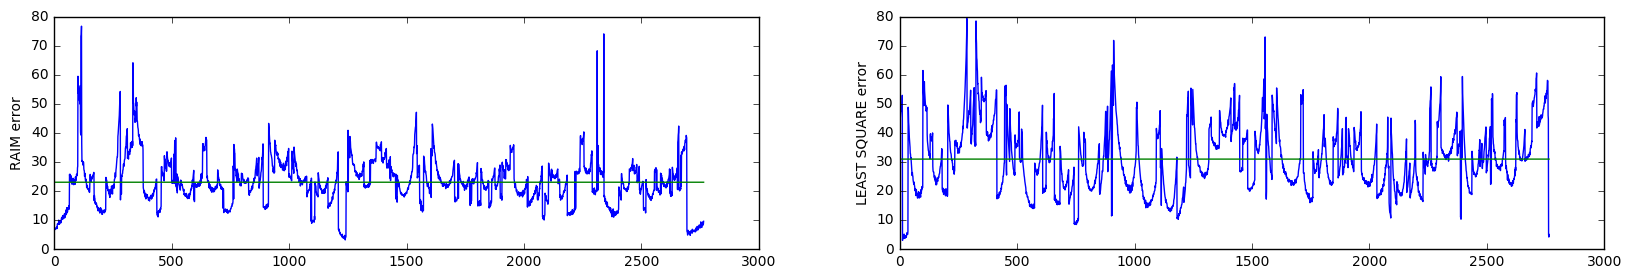

In [10]:
fig=plt.figure(figsize=(20,3))
fig.add_subplot(121)
plt.plot(raim_errs)
plt.plot([np.mean(raim_errs)]*len(raim_errs))
plt.ylabel("RAIM error")
fig.add_subplot(122)
plt.plot(ls_errs)
plt.plot([np.mean(ls_errs)]*len(ls_errs))
#plt.plot(ls_oct_errs, label="ls octave")
plt.ylabel("LEAST SQUARE error")

## comparando los metodos

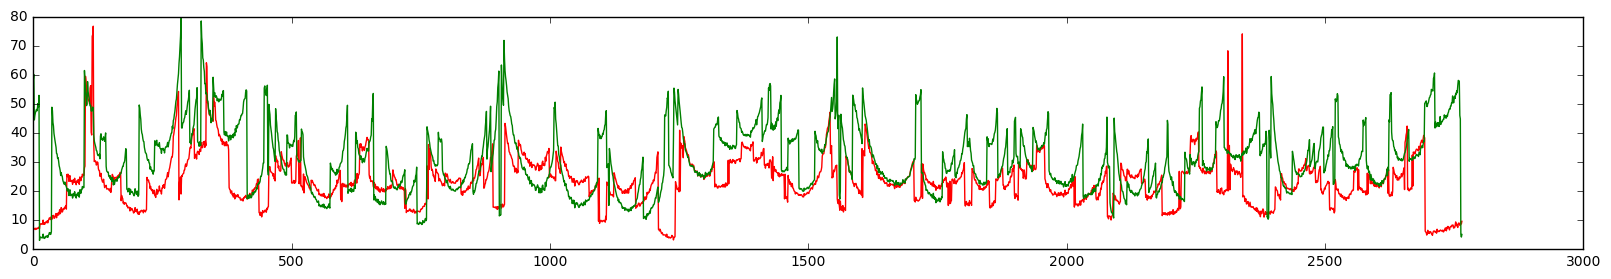

In [11]:
fig=plt.figure(figsize=(20,3))
plt.plot(raim_errs, 'r')
plt.plot(ls_errs,   'g')

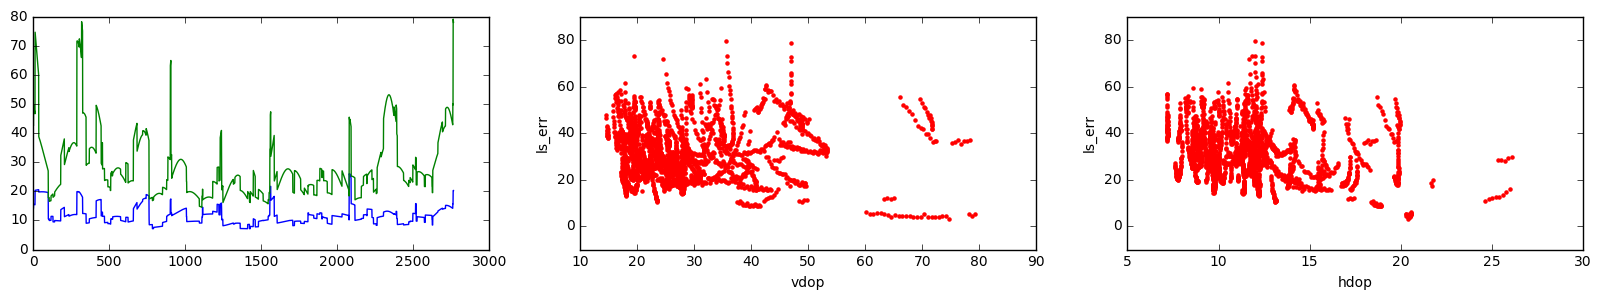

In [12]:
fig=plt.figure(figsize=(20,3))
fig.add_subplot(131)
plt.plot(hdops, label="hdop")
plt.plot(vdops, label="vdop")
fig.add_subplot(132)
plt.scatter(vdops, ls_errs, s=5, color="red")
plt.xlabel("vdop"); plt.ylabel("ls_err")
fig.add_subplot(133)
plt.scatter(hdops, ls_errs, s=5, color="red")
plt.xlabel("hdop"); plt.ylabel("ls_err")


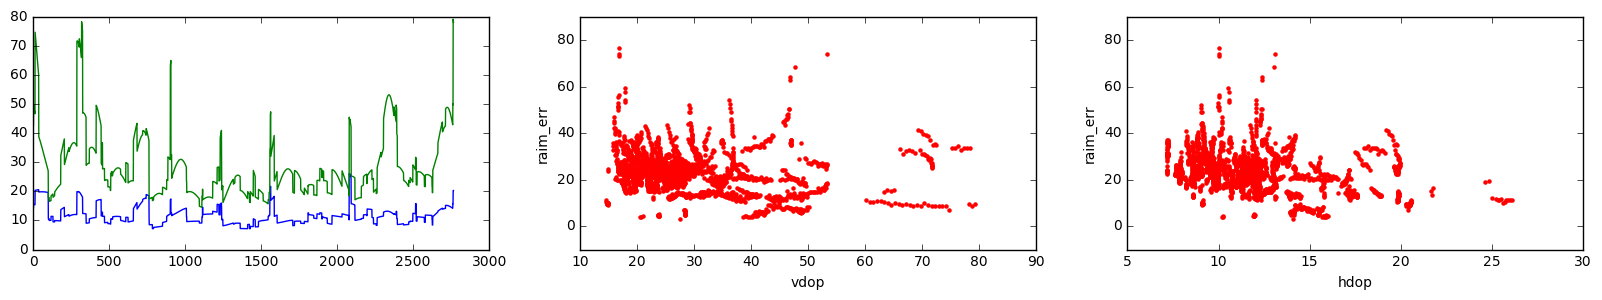

In [13]:
fig=plt.figure(figsize=(20,3))
fig.add_subplot(131)
plt.plot(hdops, label="hdop")
plt.plot(vdops, label="vdop")
fig.add_subplot(132)
plt.scatter(vdops, raim_errs, s=5, color="red")
plt.xlabel("vdop"); plt.ylabel("raim_err")
fig.add_subplot(133)
plt.scatter(hdops, raim_errs, s=5, color="red")
plt.xlabel("hdop"); plt.ylabel("raim_err")


## Symbolically solving for least squares as shown [here](http://www.nbmg.unr.edu/staff/pdfs/blewitt%20basics%20of%20gps.pdf)

First define symbols and matrices

In [14]:
init_printing(use_latex=True)

In [15]:
o = data.iloc[12]
c_val = 299792458
raim_computed_pos     = compute_raim_position(o.gps_week, o.gps_sow, o.prns, o.prns_pos, o.P1, bcestore)
ls_computed_pos,_,_,_ = compute_least_squares_position(o.prns_pos, o.prns_clockbias, o.P1, apply_earth_rotation=False)
ls_computed_pos, np.linalg.norm(ls_computed_pos[:3]-rec_pos)

(array([ 3898734.68755328,   855366.36096146,  4958372.37414654,
           55824.763414  ]), 21.416074788869494)

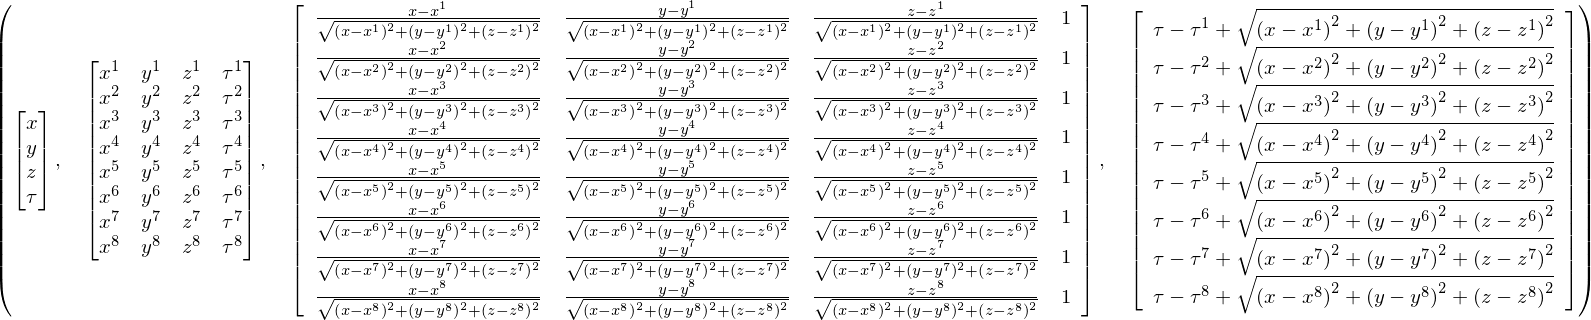

In [16]:
n=len(o.prns)
x,y,z,u = symbols("x y z \\tau")
X = Matrix(4,1,[x,y,z,u])
A = Matrix(MatrixSymbol("A",n,X.shape[0]))
P = Matrix(MatrixSymbol("A",n,1))
vnames = ["x", "y", "z", "\\tau"]
O_sats = Matrix(n, X.shape[0], lambda i,j:var(vnames[j]+'^{%d}' % (i+1)))
for i in range(n):
    P[i]   = sqrt(sum((X[:3,:].T - O_sats[i,:3]).applyfunc(lambda x: pow(x,2))))+(u-O_sats[i,3])
    A[i,:] = [[diff(P[i],x), diff(P[i],y), diff(P[i], z), diff(P[i], u)]]
    
X, O_sats, A, P

Then, obtain observables and set initial $X$ value for Taylor approximation. Note that we take into account earth rotation to obtain sats position at send time.

In [17]:
rpos = []
we = 7.2921159e-5
pos = np.array(o.prns_pos)
for i in range(len(pos)):
    dt = o.P1[i]/c
    theta = we*dt
    R = np.array([[np.cos(theta), np.sin(theta),0.],[-np.sin(theta), np.cos(theta),0.],[0.,0.,1.]])
    rpos.append(R.dot(pos[i]))
svs = np.array(rpos)


clocks = c*o.prns_clockbias.reshape(-1,1)
P_observed_vals = o.P1.reshape(-1,1)
O_sats_vals = np.hstack((svs, clocks))
X_vals = np.zeros(4).reshape(-1,1)
print O_sats_vals, X_vals, P_observed_vals

[[  7.81883281e+06   1.95991148e+07   1.67397679e+07   1.61641730e+05]
 [ -6.75055983e+06   1.37282670e+07   2.17009962e+07   1.19371683e+04]
 [  1.08700374e+07   1.48573376e+07   1.91518455e+07   7.73094318e+04]
 [  1.91702315e+07  -1.51440013e+07   1.04736924e+07   3.03044346e+04]
 [  2.21386908e+07   1.48058805e+07  -5.18000911e+04  -1.22910497e+04]
 [  1.48291983e+07   2.78076022e+05   2.19523778e+07   1.81864756e+03]
 [  2.45413765e+07  -2.99134968e+06   9.68320884e+06   1.74808548e+05]
 [  4.67171202e+06  -1.47501280e+07   2.16917845e+07   9.78415588e+04]] [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]] [[ 22377444.101]
 [ 23696271.336]
 [ 21099818.727]
 [ 22820609.186]
 [ 23571632.665]
 [ 20267974.433]
 [ 21404018.752]
 [ 22851987.727]]


Substitute observations and initial solution into equations

In [18]:
X_vals = np.zeros(4)
A_vals = A
P_computed = P
for j in range(O_sats.shape[1]):
    A_vals     = A_vals.subs({X[j]: X_vals[j]})
    P_computed = P_computed.subs({X[j]: X_vals[j]})
    for i in range(O_sats.shape[0]):
        A_vals     = A_vals.subs({O_sats[i,j]: O_sats_vals[i,j]})
        P_computed = P_computed.subs({O_sats[i,j]: O_sats_vals[i,j]})


Solve for position

In [19]:
print type(P_computed), type(P_observed_vals)

<class 'sympy.matrices.dense.MutableDenseMatrix'> <type 'numpy.ndarray'>


In [20]:
b = -P_computed+P_observed_vals
nA = lambdify( (), A_vals )()
nb = lambdify( (), b      )()

print type(nA), type(nb), type(np.linalg.lstsq(nA,nb))
print np.linalg.lstsq(nA,nb)[0]

<type 'numpy.ndarray'> <type 'numpy.ndarray'> <type 'tuple'>
[[ 4690872.87246531]
 [ 1041835.16599247]
 [ 5986238.17563729]
 [ 1413535.93243822]]


And now iteratively

In [21]:
X0 = np.zeros(4).reshape(-1,1)

for i in range(10):

    A_vals = A
    P_computed = P
    for j in range(O_sats.shape[1]):
        A_vals = A_vals.subs({X[j]: X0[j]})
        P_computed = P_computed.subs({X[j]: X0[j]})
        for i in range(O_sats.shape[0]):
            A_vals = A_vals.subs({O_sats[i,j]: O_sats_vals[i,j]})
            P_computed = P_computed.subs({O_sats[i,j]: O_sats_vals[i,j]})

    b = -P_computed+P_observed_vals
    nA = lambdify( (), A_vals )()
    nb = lambdify( (), b      )()
    
    delta = np.linalg.lstsq(nA,nb)[0]
    X0 += delta
    print X0[:,0]
X0

[ 4690872.87246531  1041835.16599247  5986238.17563729  1413535.93243822]
[ 3925099.05944619   862094.91248527  4994132.59287001   105140.82853579]
[ 3898771.49118983   855353.80771644  4958417.29276454    55884.91567938]
[ 3898739.72486714   855345.01469298  4958372.9694438     55825.23828199]
[ 3898739.72482344   855345.01467824  4958372.96938168    55825.23819549]
[ 3898739.72482344   855345.01467824  4958372.96938167    55825.23819549]
[ 3898739.72482344   855345.01467824  4958372.96938168    55825.23819549]
[ 3898739.72482344   855345.01467824  4958372.96938168    55825.23819549]
[ 3898739.72482344   855345.01467824  4958372.96938167    55825.23819549]
[ 3898739.72482344   855345.01467824  4958372.96938168    55825.23819549]


array([[ 3898739.72482344],
       [  855345.01467824],
       [ 4958372.96938168],
       [   55825.23819549]])

In [22]:
%run -i ./code/utils.py
ls_computed_pos,_,_,_ = compute_least_squares_position(o.prns_pos, o.prns_clockbias, o.P1)
print "LS numeric ", ls_computed_pos
print "LS symbolic", X0[:,0]
print "LS numeric error", np.linalg.norm(ls_computed_pos[:3]-rec_pos)
print "LS symbolic error ", np.linalg.norm(X0[:3,0]-rec_pos)


LS numeric  [ 3898739.72482344   855345.01467824  4958372.96938168    55825.23819549]
LS symbolic [ 3898739.72482344   855345.01467824  4958372.96938168    55825.23819549]
LS numeric error 3.10883169705
LS symbolic error  3.10883169704


## Using Python optimization directly from the positioning equations 
to get the same solution as with least squares

substitute observed values into equation

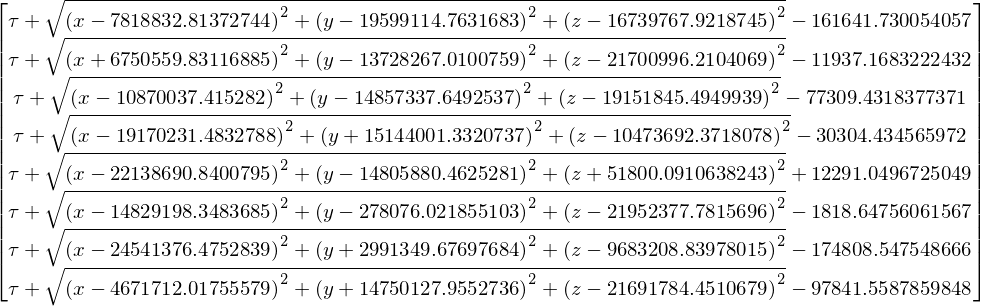

In [23]:
P_computed = P
for j in range(O_sats.shape[1]):
    for i in range(O_sats.shape[0]):
        P_computed = P_computed.subs({O_sats[i,j]: O_sats_vals[i,j]})
P_computed

Build cost function

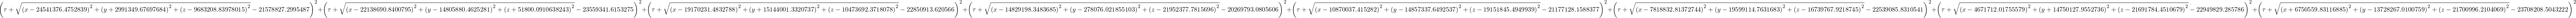

In [24]:
J = 0
for i in range(len(P_observed_vals)):
    J += (P_computed[i]-P_observed_vals[i])**2
J

transform the symbolic cost function into a numpy evaluable function 

In [25]:
Jf  = lambda a: lambdify([x,y,z,u], J, "numpy")(a[0], a[1], a[2], a[3])

minimize and check results

In [26]:
from scipy.optimize import minimize

res = minimize(Jf, np.array([0,0,0,0]), method='SLSQP', options={'disp': True})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 106.652026675
            Iterations: 32
            Function evaluations: 258
            Gradient evaluations: 32


In [27]:
print "LS pos  ", ls_computed_pos
print "LS cost ", Jf(ls_computed_pos)
print "LS err  ", np.linalg.norm(ls_computed_pos[:3]-rec_pos)
print "MIN pos ", res.x
print "MIN cost", Jf(res.x)
print "MIN err ", np.linalg.norm(res.x[:3]-rec_pos)

LS pos   [ 3898739.72482344   855345.01467824  4958372.96938168    55825.23819549]
LS cost  106.105171444
LS err   3.10883169705
MIN pos  [ 3898739.42025521   855345.10755639  4958372.04364454    55824.70403698]
MIN cost 106.652026675
MIN err  2.72905922988


and, finally, using the `jac` argument to provide derivatives to the optimization method so that it requires much lest function evaluations. we nicely use `sympy` to compute the derivatives for us 

In [28]:
dJx = lambda a: lambdify([x,y,z,u], diff(J,x), "numpy")(a[0], a[1], a[2], a[3])
dJy = lambda a: lambdify([x,y,z,u], diff(J,y), "numpy")(a[0], a[1], a[2], a[3])
dJz = lambda a: lambdify([x,y,z,u], diff(J,z), "numpy")(a[0], a[1], a[2], a[3])
dJu = lambda a: lambdify([x,y,z,u], diff(J,u), "numpy")(a[0], a[1], a[2], a[3])
dJ  = lambda a: np.array([dJx(a), dJy(a), dJz(a), dJu(a)])

In [29]:
res = minimize(Jf, np.array([0,0,0,0]), jac=dJ, method='SLSQP', options={'disp': True})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 106.105171414
            Iterations: 14
            Function evaluations: 17
            Gradient evaluations: 14


In [30]:
print "LS pos  ", ls_computed_pos
print "LS cost ", Jf(ls_computed_pos)
print "LS err  ", np.linalg.norm(ls_computed_pos[:3]-rec_pos)
print "MIN pos ", res.x
print "MIN cost", Jf(res.x)
print "MIN err ", np.linalg.norm(res.x[:3]-rec_pos)

LS pos   [ 3898739.72482344   855345.01467824  4958372.96938168    55825.23819549]
LS cost  106.105171444
LS err   3.10883169705
MIN pos  [ 3898739.72489126   855345.01468763  4958372.96946912    55825.2382784 ]
MIN cost 106.105171414
MIN err  3.1089177795
